In [122]:
%load_ext pycodestyle_magic
%flake8_on

# Import

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, date
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.manifold import TSNE
from category_encoders import TargetEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import InterclusterDistance

# Load Data

In [124]:
df = pd.read_csv('./df_clean.csv', index_col=0)

In [126]:
df.mean_review_score.fillna(df.mean_review_score.mean(), inplace=True)

In [127]:
df

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,5.0
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,4.0
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,0.033932,4.0
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,0.020498,5.0
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,0.004672,5.0
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,661.587442,85.08,1,0.423539,5.0
126124,da62f9e57a76d978d02ab5362c509660,327.459051,195.00,1,0.423539,4.0
126125,737520a9aad80b3fbbdad19b66b37b30,490.384225,271.01,1,0.033932,5.0
126126,5097a5312c8b157bb7be58ae360ef43c,356.105243,441.16,1,0.129691,2.0


In [129]:
features_to_normalized = ['recently_order',
                          'cum_sum_order',
                          'number_of_orders',
                          'customer_state_encode',
                          'mean_review_score']
df_normalised = df.copy()
for feature in features_to_normalized:
    scaler = StandardScaler()
    df_normalised[feature] = scaler.fit_transform(df_normalised[[feature]])

In [130]:
df_normalised.head()

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,0.663862
1,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,-0.116841
8,af07308b275d755c9edb36a90c618231,-1.346400,-0.067792,-0.186531,-1.035537,-0.116841
9,3a653a41f6f9fc3d2a113cf8398680e8,-1.442142,0.187240,-0.186531,-1.110879,0.663862
10,7c142cf63193a1473d2e66489a9ae977,0.291675,-0.536817,-0.186531,-1.199632,0.663862


# Usefull fonctions

In [132]:
def mean_per_cluster(data, feature, cluster_name):
    means = {}
    for cluster in list(data[cluster_name].unique()):
        means[cluster] = data[data[cluster_name] == cluster][feature].mean()
    return means


def ploting(data, features_to_evaluate, cluster_name):
    for ind, feature in enumerate(features_to_evaluate):
        sns.boxplot(x=cluster_name, y=feature, data=data, orient='v')
        plt.title(f'{feature}')
        plt.show()
        means = mean_per_cluster(data, feature, cluster_name)
        [print(key, '-->', value) for key, value in means.items()]


In [156]:
def display_circles(pcs,
                    n_comp,
                    pca,
                    axis_ranks,
                    labels=None,
                    label_rotation=0,
                    lims=None):
    # On affiche les 3 premiers plans factoriels,
    # donc les 6 premières composantes
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7, 6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]),
                max(pcs[d1, :]), min(pcs[d2, :]),
                max(pcs[d2, :])
            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche
            # pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy',
                           scale=1, color="grey")
            # (voir la doc :
            # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(lines,
                                                 axes=ax,
                                                 alpha=.1,
                                                 color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i],
                                 fontsize='14',
                                 ha='center',
                                 va='center',
                                 rotation=label_rotation,
                                 color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            d1_explained_var = pca.explained_variance_ratio_[d1]
            d2_explained_var = pca.explained_variance_ratio_[d2]
            plt.xlabel('F{} ({}%)'.format(d1+1,
                                          round(100 *
                                                d1_explained_var,
                                                1)))
            plt.ylabel('F{} ({}%)'.format(d2+1,
                                          round(100 *
                                                d2_explained_var,
                                                1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1,
                                                                    d2+1))
            plt.show(block=False)


def display_factorial_planes(X_projected,
                             n_comp,
                             pca,
                             axis_ranks,
                             labels=None,
                             alpha=1,
                             illustrative_var=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            # initialisation de la figure
            fig = plt.figure(figsize=(7, 6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2],
                            alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1],
                                X_projected[selected, d2],
                                alpha=alpha,
                                label=value)
                plt.legend()
            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([- boundary, boundary])
            plt.ylim([- boundary, boundary])
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1 + 1, round(
                100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(d2 + 1, round(
                100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("Projection des individus (sur F{} et F{})".format(
                d1 + 1, d2 + 1))
            plt.show(block=False)


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

91:13: F841 local variable 'fig' is assigned to but never used


In [159]:
def lineploting(data, value_vars):
    metlted_df = pd.melt(data.reset_index(),
                         id_vars=['customer_unique_id', 'clusters'],
                         value_vars=value_vars,
                         var_name='Feature',
                         value_name='Value')
    sns.lineplot('Feature', 'Value', hue='clusters', data=metlted_df)
    plt.show()

In [161]:
def ploting_3d(data, features: list, sample_: int):
    data_to_plot = data.sample(sample_)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_to_plot[features[0]],
               data_to_plot[features[1]],
               data_to_plot[features[2]],
               cmap='brg', c=data_to_plot['clusters'])
    plt.show()

# RFM

## Determined number of clusters

In [162]:
df.head()

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,5.0
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,4.0
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,0.033932,4.0
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,0.020498,5.0
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,0.004672,5.0


In [164]:
rfm_k_mean = df[['customer_unique_id',
                 'recently_order',
                 'cum_sum_order',
                 'number_of_orders']].drop_duplicates()

In [165]:
rfm_k_mean.head()

,customer_unique_id,recently_order,cum_sum_order,number_of_orders
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1
11,72632f0f9dd73dfee390c9b22eb56dd6,320.112049,28.62,1


In [167]:
metric = {}
X_rfm = rfm_k_mean[['recently_order', 'cum_sum_order', 'number_of_orders']]
for i in range(1, 10):
    k_means = KMeans(n_clusters=i)
    k_means.fit(X_rfm)
    rfm_k_mean["clusters"] = k_means.labels_
    metric[i] = k_means.inertia_

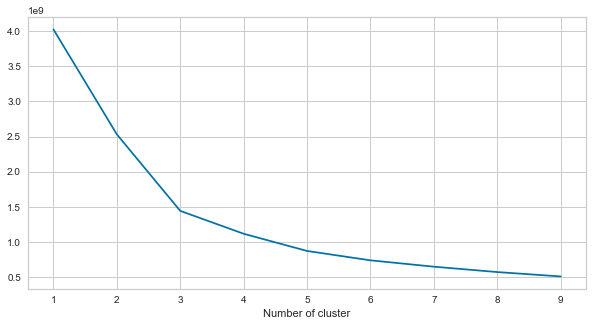

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(list(metric.keys()), list(metric.values()))
plt.xlabel("Number of cluster")
plt.show()

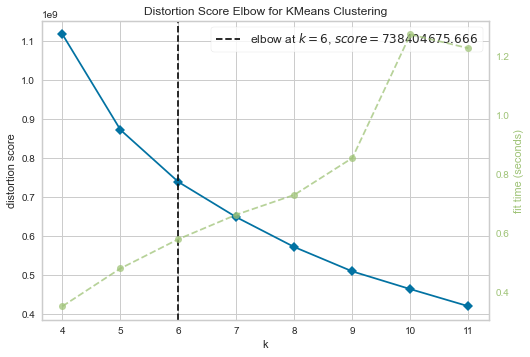

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [170]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 12))

visualizer.fit(X_rfm)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

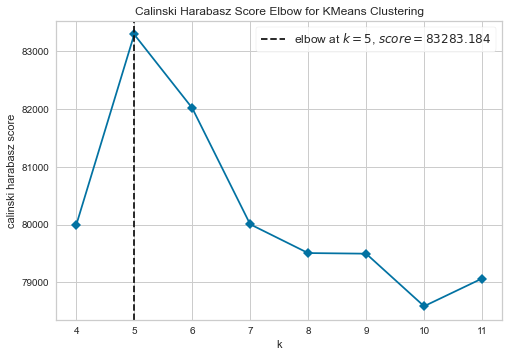

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [172]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 12),
                              metric='calinski_harabasz',
                              timings=False)

visualizer.fit(X_rfm)    # Fit the data to the visualizer
visualizer.poof()

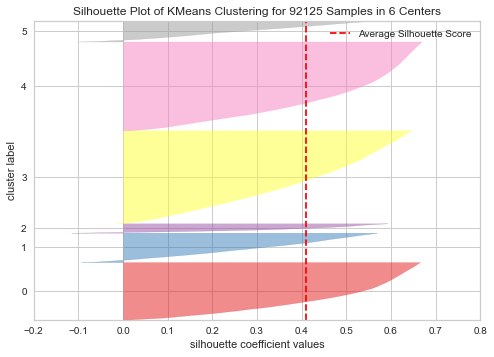

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92125 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [174]:
# Instantiate the clustering model and visualizer
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_rfm)   # Fit the data to the visualizer
visualizer.poof()

# PCA

In [175]:
df_normalised

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,0.663862
1,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,1.149382,-0.116841
8,af07308b275d755c9edb36a90c618231,-1.346400,-0.067792,-0.186531,-1.035537,-0.116841
9,3a653a41f6f9fc3d2a113cf8398680e8,-1.442142,0.187240,-0.186531,-1.110879,0.663862
10,7c142cf63193a1473d2e66489a9ae977,0.291675,-0.536817,-0.186531,-1.199632,0.663862
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,1.971667,-0.449594,-0.186531,1.149382,0.663862
126124,da62f9e57a76d978d02ab5362c509660,-0.234843,0.294779,-0.186531,1.149382,-0.116841
126125,737520a9aad80b3fbbdad19b66b37b30,0.841079,0.809515,-0.186531,-1.035537,0.663862
126126,5097a5312c8b157bb7be58ae360ef43c,-0.045670,1.961762,-0.186531,-0.498519,-1.678248


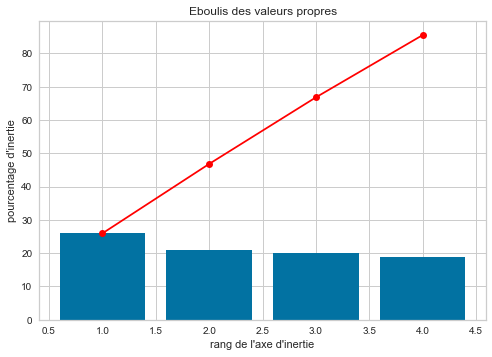

In [182]:
X = df_normalised[['recently_order',
                   'cum_sum_order',
                   'number_of_orders',
                   'mean_review_score',
                   'customer_state_encode']]
N_COMP = 4
features = df_normalised[['recently_order',
                          'cum_sum_order',
                          'number_of_orders',
                          'mean_review_score',
                          'customer_state_encode']].columns

# std_scale = StandardScaler().fit(X)
# X_scaled = std_scale.transform(X)
pca = PCA(n_components=N_COMP)
pca.fit(X)
display_scree_plot(pca)

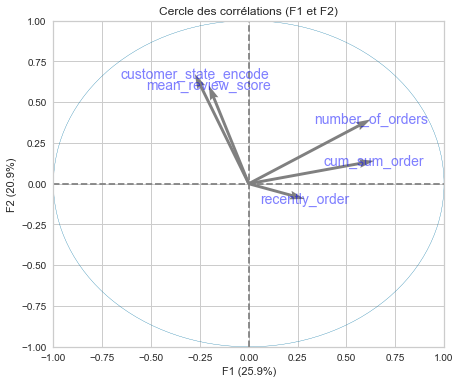

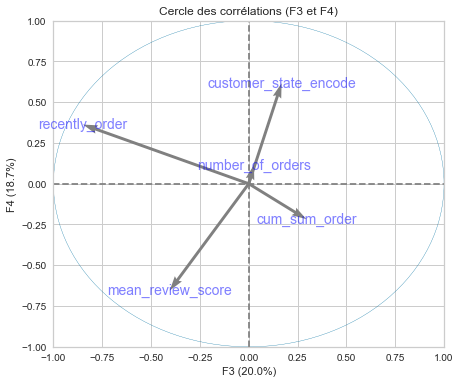

In [187]:
pcs = pca.components_
display_circles(pcs, N_COMP, pca, [(0, 1), (2, 3), (4, 5)],
                labels=np.array(features))

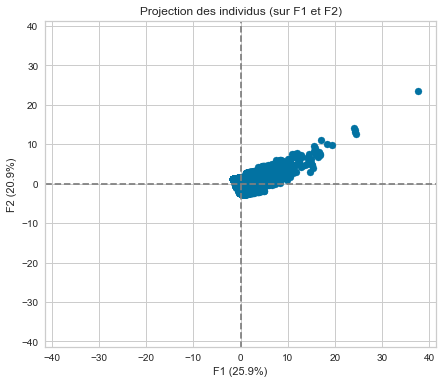

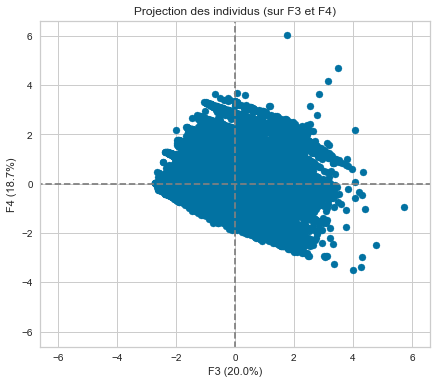

In [188]:
X_projected = pca.transform(X)
display_factorial_planes(X_projected, N_COMP, pca, [(0, 1), (2, 3), (4, 5)])
plt.show()

In [189]:
customer_id = df_normalised['customer_unique_id'].reset_index()

In [190]:
df_pca = pd.DataFrame(X_projected)

In [191]:
df_pca = pd.concat([df_pca, customer_id], axis=1)

# entrainement RFM

In [192]:
k_means = KMeans(n_clusters=5)
k_means.fit(rfm_k_mean[['recently_order',
                        'cum_sum_order',
                        'number_of_orders']])
rfm_k_mean["clusters"] = k_means.labels_

In [193]:
rfm_k_mean["clusters"].value_counts()

1    29997
4    29231
0    20315
3     9707
2     2875
Name: clusters, dtype: int64

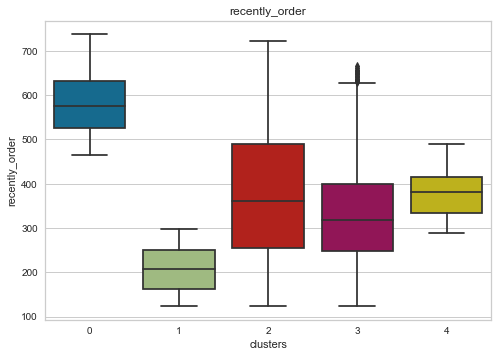

4 --> 378.8762782975048
1 --> 208.42749004066937
0 --> 580.3176676203942
2 --> 378.9582908212558
3 --> 325.49234931645515


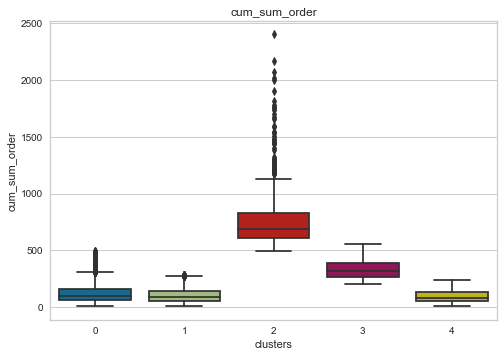

4 --> 96.44107078101943
1 --> 105.01598393172513
0 --> 121.21210632537588
2 --> 731.2827478260878
3 --> 332.3476923869371


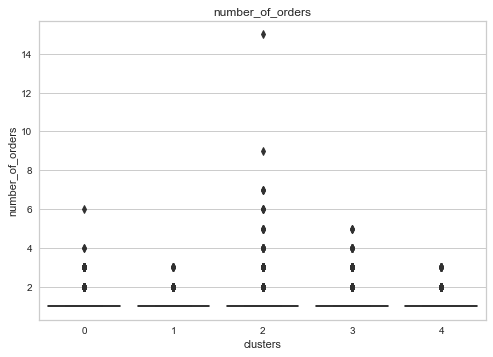

4 --> 1.0193287947726728
1 --> 1.0097009700970097
0 --> 1.0451882845188285
2 --> 1.1655652173913043
3 --> 1.0873596373750902


In [194]:
ploting(rfm_k_mean, ['recently_order',
                     'cum_sum_order',
                     'number_of_orders'], 'clusters')

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


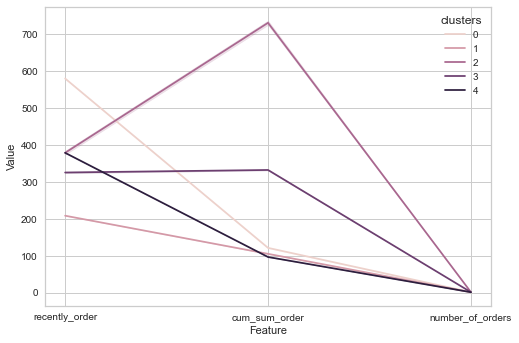

In [195]:
lineploting(rfm_k_mean, ['recently_order',
                         'cum_sum_order',
                         'number_of_orders'])

In [196]:
test = rfm_k_mean.copy()

<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

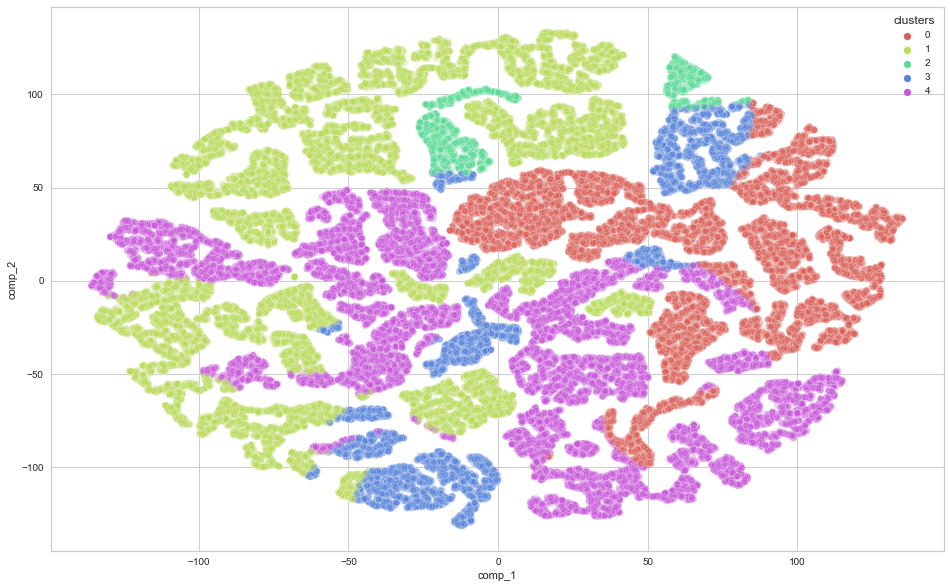

4:5: E122 continuation line missing indentation or outdented
15:9: E251 unexpected spaces around keyword / parameter equals
15:11: E251 unexpected spaces around keyword / parameter equals


In [197]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random',
                  perplexity=50).fit_transform(rfm_k_mean[
    ['recently_order',
     'cum_sum_order',
     'number_of_orders']])
test['comp_1'] = X_embedded[:, 0]
test['comp_2'] = X_embedded[:, 1]
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='comp_1', y='comp_2',
    hue="clusters",
    palette=sns.color_palette("hls", 5),
    legend="full",
    data = test,
    alpha=0.3)

la délimitation est pas terrible sur un TSNE

# RFM avec standardisation

In [198]:
k_means = KMeans(n_clusters=5)
k_means.fit(df_normalised[['recently_order',
                           'cum_sum_order',
                           'number_of_orders']])
df_normalised["clusters"] = k_means.labels_

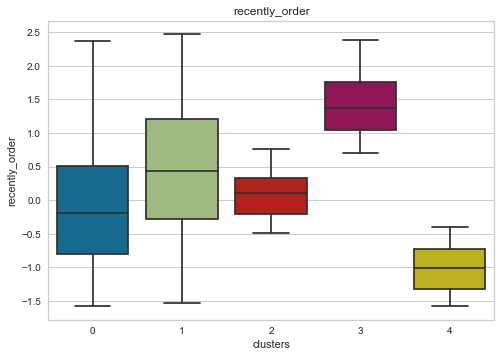

1 --> 0.45847229637115117
4 --> -1.0159907891881508
2 --> 0.08707168444985487
3 --> 1.4137220148207092
0 --> -0.08389969179095086


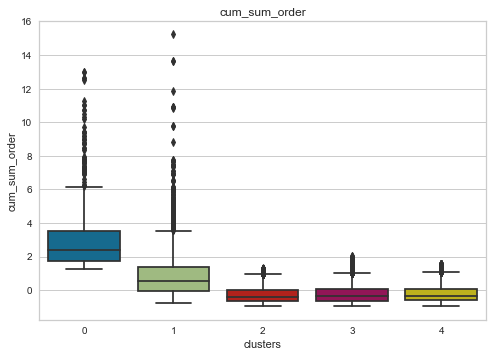

1 --> 0.9220303085215101
4 --> -0.2189258453416717
2 --> -0.26908683510140347
3 --> -0.2170979018153495
0 --> 2.781697198203434


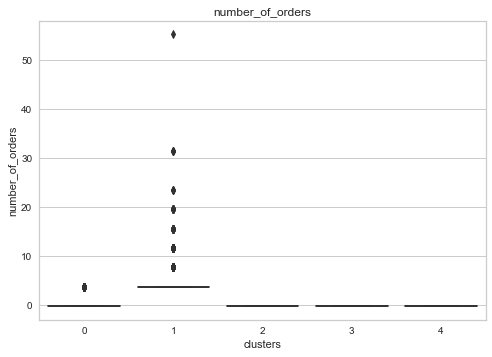

1 --> 4.320125108733247
4 --> -0.18653092209394234
2 --> -0.1865309220939432
3 --> -0.186530922093979
0 --> -0.13590814336309703


In [199]:
ploting(df_normalised, ['recently_order',
                        'cum_sum_order',
                        'number_of_orders'], 'clusters')

permet de différencier un peu mieux le nombre de commandes

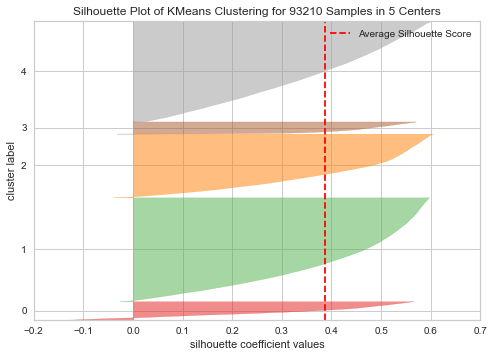

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93210 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

1:50: W291 trailing whitespace


In [200]:
# Instantiate the clustering model and visualizer

visualizer = SilhouetteVisualizer(KMeans(n_clusters=5))

visualizer.fit(df_normalised[['recently_order',
                              'cum_sum_order',
                              'number_of_orders']])
visualizer.poof()

In [202]:
a = df_normalised[['recently_order', 'cum_sum_order', 'number_of_orders']]
b = df_normalised['clusters']
silhouette_score(a, b)

0.38651835802815476

# More features

In [203]:
df

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,5.0
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,0.423539,4.0
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,0.033932,4.0
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,0.020498,5.0
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,0.004672,5.0
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,661.587442,85.08,1,0.423539,5.0
126124,da62f9e57a76d978d02ab5362c509660,327.459051,195.00,1,0.423539,4.0
126125,737520a9aad80b3fbbdad19b66b37b30,490.384225,271.01,1,0.033932,5.0
126126,5097a5312c8b157bb7be58ae360ef43c,356.105243,441.16,1,0.129691,2.0


In [206]:
df_k_mean = df[['customer_unique_id',
                'recently_order',
                'cum_sum_order',
                'number_of_orders',
                'mean_review_score',
                'customer_state_encode']].drop_duplicates()

In [205]:
X_more_features = df_k_mean[['recently_order',
                             'cum_sum_order',
                             'number_of_orders',
                             'mean_review_score',
                             'customer_state_encode']]

In [209]:
metric = {}
for i in range(1, 10):
    k_means = KMeans(n_clusters=i)
    k_means.fit(X_more_features)
    df_k_mean["clusters"] = k_means.labels_
    metric[i] = k_means.inertia_

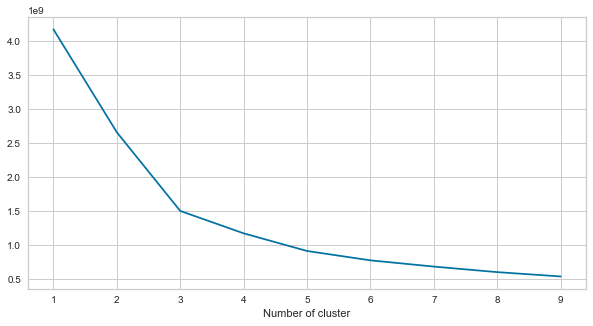

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(list(metric.keys()), list(metric.values()))
plt.xlabel("Number of cluster")
plt.show()

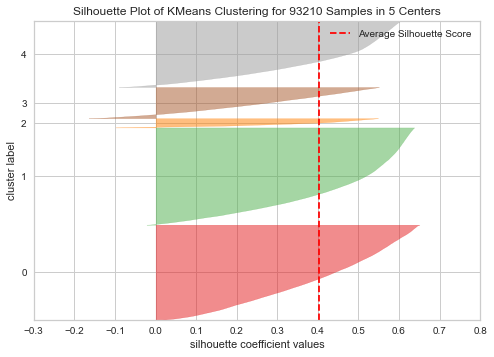

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93210 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

1:50: W291 trailing whitespace


In [210]:
# Instantiate the clustering model and visualizer 
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_more_features)    # Fit the data to the visualizer
visualizer.poof()

In [211]:
model = KMeans(n_clusters=5)
model.fit(X_more_features)
df_k_mean["clusters"] = model.labels_
df_k_mean

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,mean_review_score,customer_state_encode,clusters
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,5.0,0.423539,3
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,4.0,0.423539,3
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,4.0,0.033932,1
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,5.0,0.020498,1
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,5.0,0.004672,3
...,...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,661.587442,85.08,1,5.0,0.423539,0
126124,da62f9e57a76d978d02ab5362c509660,327.459051,195.00,1,4.0,0.423539,3
126125,737520a9aad80b3fbbdad19b66b37b30,490.384225,271.01,1,5.0,0.033932,0
126126,5097a5312c8b157bb7be58ae360ef43c,356.105243,441.16,1,2.0,0.129691,2


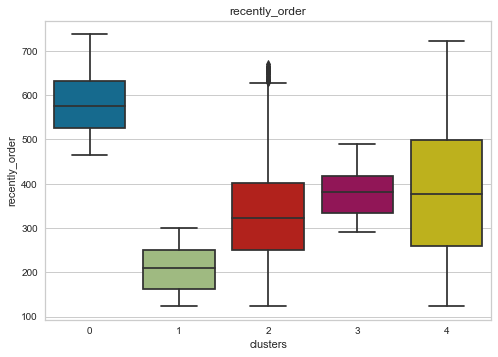

3 --> 379.30258740056206
1 --> 208.94462221315018
0 --> 580.6097683337648
4 --> 384.67355386442125
2 --> 329.2614181496035


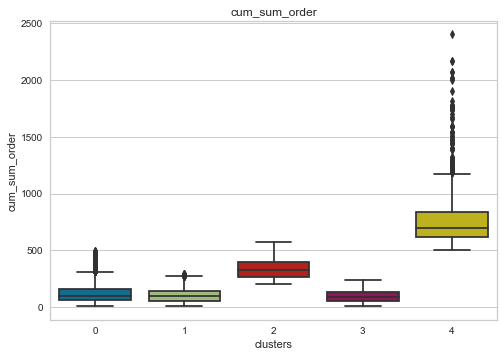

3 --> 97.66003850570696
1 --> 106.19903021137966
0 --> 122.19324703134144
4 --> 747.4773367875652
2 --> 340.9991398070214


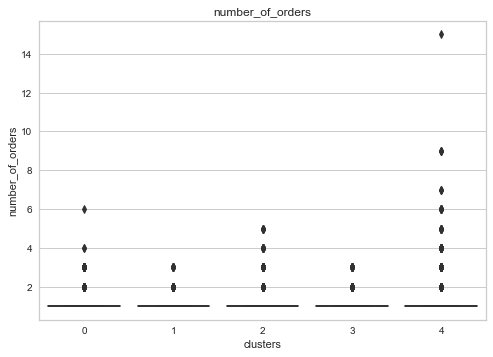

3 --> 1.0265486725663717
1 --> 1.0127880600940202
0 --> 1.0616118357017714
4 --> 1.254231433506045
2 --> 1.1241018271402177


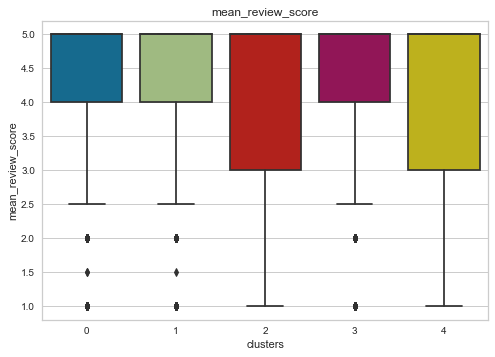

3 --> 4.067563305885088
1 --> 4.252950466051104
0 --> 4.229197549279154
4 --> 3.9848671914998786
2 --> 3.9578544971092398


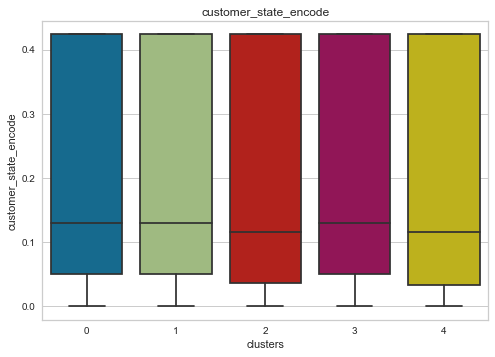

3 --> 0.2180988115908594
1 --> 0.23626961174068567
0 --> 0.2089410556881375
4 --> 0.1854350965479474
2 --> 0.19503939882679647


In [212]:
ploting(df_k_mean, ['recently_order',
                    'cum_sum_order',
                    'number_of_orders',
                    'mean_review_score',
                    'customer_state_encode'],
        'clusters')

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


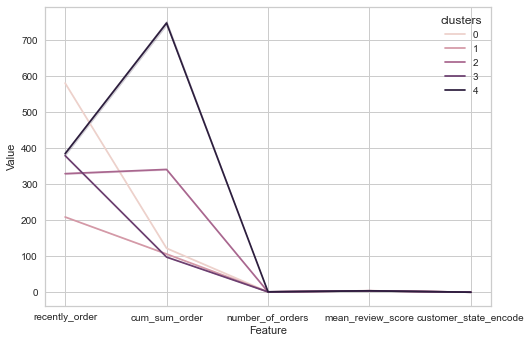

In [213]:
lineploting(df_k_mean, ['recently_order',
                        'cum_sum_order',
                        'number_of_orders',
                        'mean_review_score',
                        'customer_state_encode'])

In [214]:
df_k_mean["clusters"].value_counts()

1    30419
3    29606
0    20548
2     9742
4     2895
Name: clusters, dtype: int64

## without state

In [215]:
df_k_mean = df[['customer_unique_id',
                'recently_order',
                'cum_sum_order',
                'number_of_orders',
                'mean_review_score']].drop_duplicates()

X_more_features = df_k_mean[['recently_order',
                             'cum_sum_order',
                             'number_of_orders',
                             'mean_review_score']]

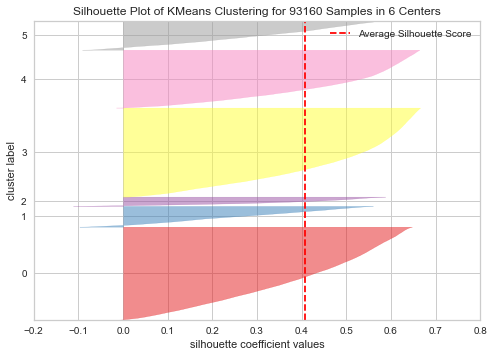

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93160 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

1:50: W291 trailing whitespace


In [216]:
# Instantiate the clustering model and visualizer
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_more_features)    # Fit the data to the visualizer
visualizer.poof()

In [217]:
model = KMeans(n_clusters=5)
model.fit(X_more_features)
df_k_mean["clusters"] = model.labels_
df_k_mean

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,mean_review_score,clusters
0,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,5.0,1
1,7c396fd4830fd04220f754e42b4e5bff,482.523171,82.82,2,4.0,1
8,af07308b275d755c9edb36a90c618231,159.137766,141.46,1,4.0,0
9,3a653a41f6f9fc3d2a113cf8398680e8,144.639711,179.12,1,5.0,0
10,7c142cf63193a1473d2e66489a9ae977,407.188819,72.20,1,5.0,1
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,661.587442,85.08,1,5.0,3
126124,da62f9e57a76d978d02ab5362c509660,327.459051,195.00,1,4.0,1
126125,737520a9aad80b3fbbdad19b66b37b30,490.384225,271.01,1,5.0,3
126126,5097a5312c8b157bb7be58ae360ef43c,356.105243,441.16,1,2.0,2


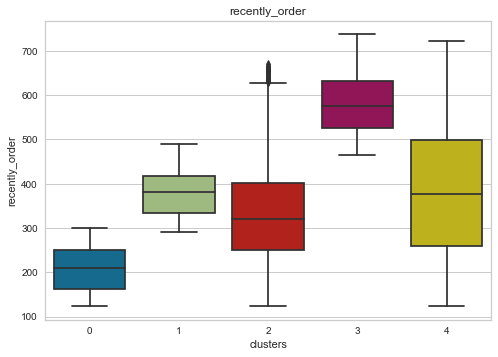

1 --> 379.27139707101423
0 --> 208.9276475049143
3 --> 580.6008856162379
4 --> 384.4126698211927
2 --> 329.1589414500193


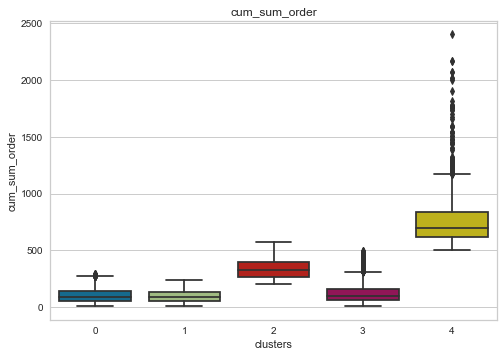

1 --> 97.65261747913789
0 --> 106.15215742385229
3 --> 122.06405455431097
4 --> 747.4417687781242
2 --> 340.8947545697271


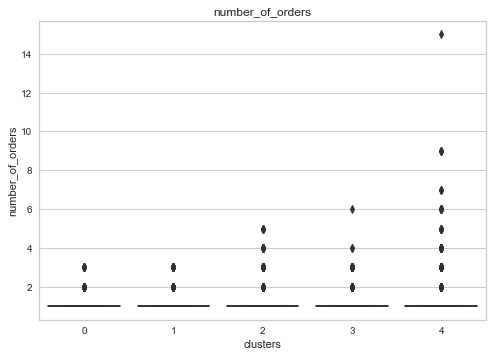

1 --> 1.0264180264180265
0 --> 1.0126307479771068
3 --> 1.0604968339016074
4 --> 1.250951886465905
2 --> 1.1228178270692133


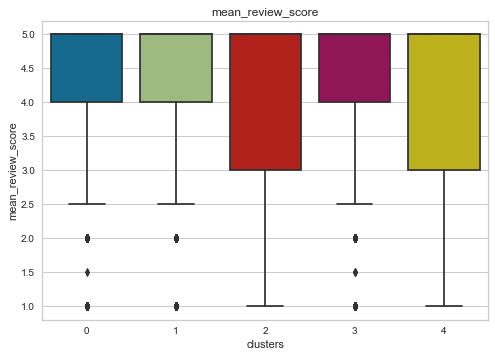

5:20: E124 closing bracket does not match visual indentation


1 --> 4.067405805007733
0 --> 4.252927446444594
3 --> 4.229593338655044
4 --> 3.9841434819633603
2 --> 3.958335268990691


In [218]:
ploting(df_k_mean, ['recently_order',
                    'cum_sum_order',
                    'number_of_orders',
                    'mean_review_score'
                   ],
        'clusters')

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


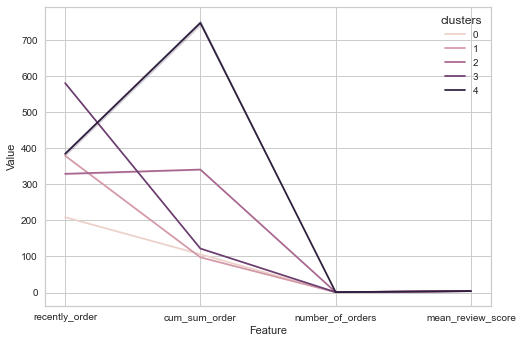

In [219]:
lineploting(df_k_mean, ['recently_order',
                        'cum_sum_order',
                        'number_of_orders',
                        'mean_review_score'])

## With normalized data

In [220]:
df_k_mean_norm = df_normalised[['customer_unique_id',
                                'recently_order',
                                'cum_sum_order',
                                'number_of_orders',
                                'mean_review_score']].drop_duplicates()

X_more_features_norm = df_k_mean_norm[['recently_order',
                                       'cum_sum_order',
                                       'number_of_orders',
                                       'mean_review_score']]

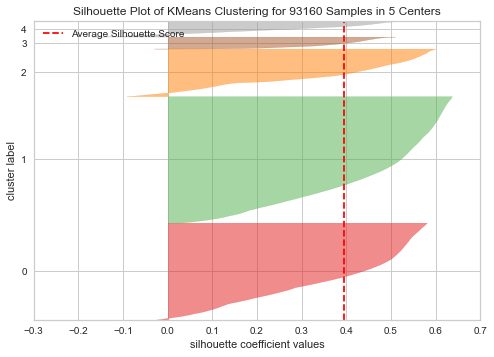

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 93160 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

1:50: W291 trailing whitespace


In [221]:
# Instantiate the clustering model and visualizer 
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_more_features_norm)    # Fit the data to the visualizer
visualizer.poof()

In [222]:
model = KMeans(n_clusters=5)
model.fit(X_more_features_norm)
df_k_mean_norm["clusters"] = model.labels_
df_k_mean_norm

,customer_unique_id,recently_order,cum_sum_order,number_of_orders,mean_review_score,clusters
0,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,0.663862,4
1,7c396fd4830fd04220f754e42b4e5bff,0.789166,-0.464899,3.777570,-0.116841,4
8,af07308b275d755c9edb36a90c618231,-1.346400,-0.067792,-0.186531,-0.116841,0
9,3a653a41f6f9fc3d2a113cf8398680e8,-1.442142,0.187240,-0.186531,0.663862,0
10,7c142cf63193a1473d2e66489a9ae977,0.291675,-0.536817,-0.186531,0.663862,2
...,...,...,...,...,...,...
126123,6359f309b166b0196dbf7ad2ac62bb5a,1.971667,-0.449594,-0.186531,0.663862,2
126124,da62f9e57a76d978d02ab5362c509660,-0.234843,0.294779,-0.186531,-0.116841,0
126125,737520a9aad80b3fbbdad19b66b37b30,0.841079,0.809515,-0.186531,0.663862,2
126126,5097a5312c8b157bb7be58ae360ef43c,-0.045670,1.961762,-0.186531,-1.678248,3


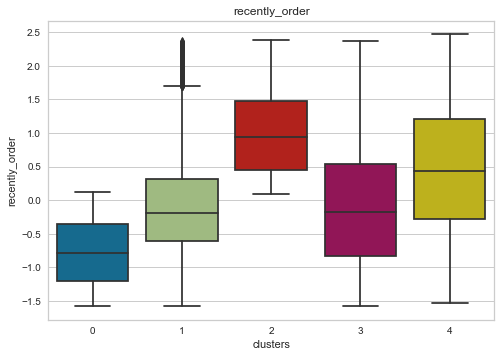

4 --> 0.45626389709105053
0 --> -0.7789950999255428
2 --> 1.0000079811770992
1 --> -0.06226435077267382
3 --> -0.06942881714432039


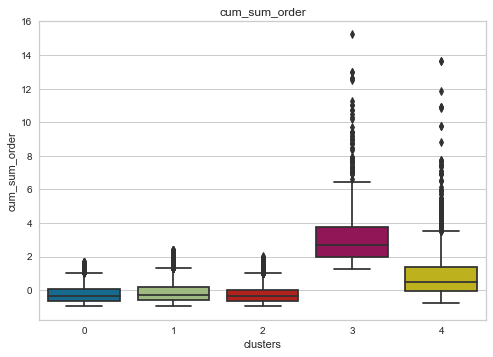

4 --> 0.9013508707488282
0 --> -0.23988234679509535
2 --> -0.2316313145093146
1 --> -0.1212281382287244
3 --> 3.0343194137342255


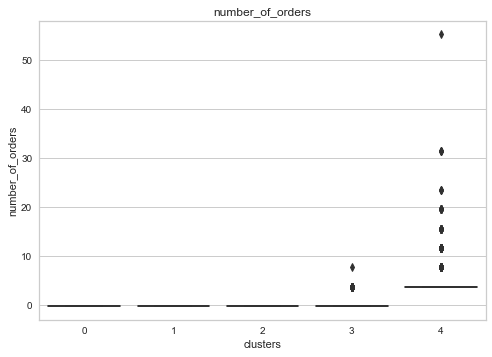

4 --> 4.320641355307969
0 --> -0.18653092209393043
2 --> -0.1865309220939458
1 --> -0.18653092209401428
3 --> -0.11525162228519807


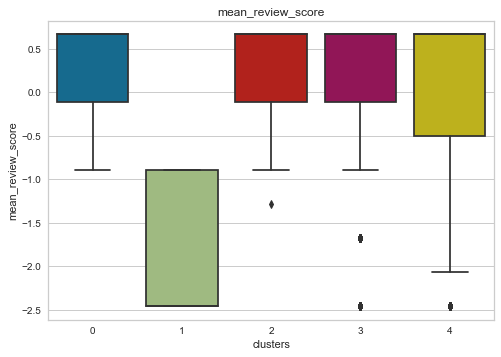

4 --> -0.08251818171627795
0 --> 0.42786277532999367
2 --> 0.3790950728054445
1 --> -1.899150421685898
3 --> 0.03388921596190389


In [224]:
ploting(df_k_mean_norm, ['recently_order',
                         'cum_sum_order',
                         'number_of_orders',
                         'mean_review_score'],
        'clusters')

In [225]:
df_k_mean_norm.clusters.value_counts()

0    39437
2    30252
1    14847
3     4894
4     3730
Name: clusters, dtype: int64

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


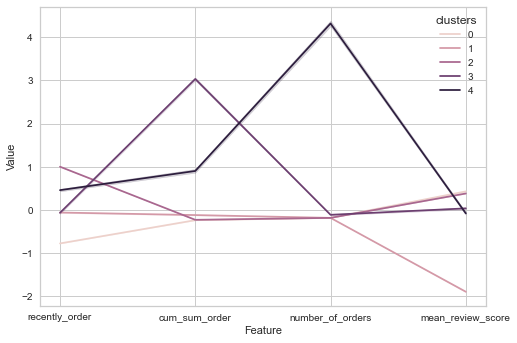

In [226]:
lineploting(df_k_mean_norm, ['recently_order',
                             'cum_sum_order',
                             'number_of_orders',
                             'mean_review_score'])

In [227]:
df_k_mean_norm_ = df_k_mean_norm.sample(1000)

In [228]:
df_k_mean_norm_.clusters.value_counts()

0    425
2    322
1    147
3     62
4     44
Name: clusters, dtype: int64

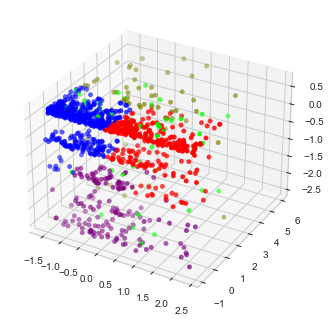

In [229]:
ploting_3d(df_k_mean_norm_, ['recently_order',
                             'cum_sum_order',
                             'mean_review_score'], 1000)

In [230]:
a = df_k_mean_norm[['recently_order',
                    'cum_sum_order',
                    'number_of_orders',
                    'mean_review_score']]
b = df_k_mean_norm['clusters']
silhouette_score(a, b)

0.3944822014582615

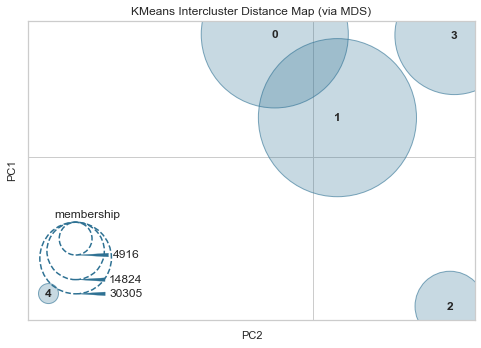

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

8:80: E501 line too long (93 > 79 characters)


In [231]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = InterclusterDistance(model)

visualizer.fit(df_k_mean_norm[['recently_order',
                               'cum_sum_order',
                               'number_of_orders',
                               'mean_review_score']])
visualizer.show()        # Finalize and render the figure

In [232]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random',
                  perplexity=30).fit_transform(
    df_k_mean_norm[['recently_order',
                    'cum_sum_order',
                    'number_of_orders',
                    'mean_review_score']])

1:56: W291 trailing whitespace


<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

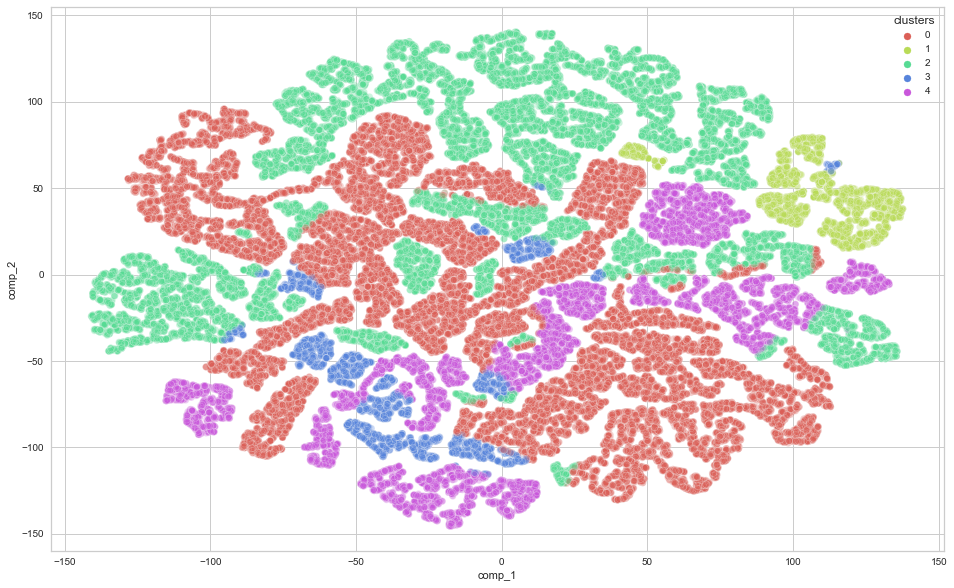

In [63]:
df_k_mean_norm['comp_1'] = X_embedded[:,0]
df_k_mean_norm['comp_2'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='comp_1', y='comp_2',
    hue="clusters",
    palette=sns.color_palette("hls", 5),
    legend="full",
    data = df_k_mean_norm,
    alpha=0.3
)

## With data pca

In [233]:
model = KMeans(n_clusters=6)
model.fit(X_projected)
df_pca["clusters"] = model.labels_
df_pca

,0,1,2,3,index,customer_unique_id,clusters
0,1.831380,2.524045,-0.781552,1.093201,0,7c396fd4830fd04220f754e42b4e5bff,2
1,1.991184,2.053160,-0.465502,1.604606,1,7c396fd4830fd04220f754e42b4e5bff,2
2,-0.234364,-0.724275,0.990791,-1.055981,8,af07308b275d755c9edb36a90c618231,3
3,-0.237194,-0.259416,0.818544,-1.703863,9,3a653a41f6f9fc3d2a113cf8398680e8,3
4,-0.182050,-0.582450,-0.881274,-0.972583,10,7c142cf63193a1473d2e66489a9ae977,0
...,...,...,...,...,...,...,...
93205,-0.295084,0.852860,-1.886264,1.064027,126123,6359f309b166b0196dbf7ad2ac62bb5a,4
93206,-0.287808,0.692309,0.521806,0.613682,126124,da62f9e57a76d978d02ab5362c509660,1
93207,0.792595,-0.334886,-0.922808,-0.964616,126125,737520a9aad80b3fbbdad19b66b37b30,0
93208,1.609395,-1.142161,1.207996,0.328531,126126,5097a5312c8b157bb7be58ae360ef43c,5


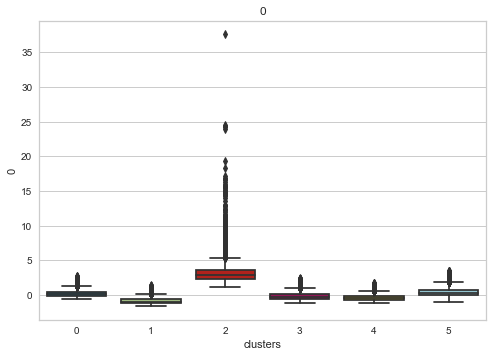

2 --> 3.237783978946663
3 --> -0.16017384832092332
0 --> 0.21233231627192253
1 --> -0.8497678075209145
5 --> 0.37513339958711817
4 --> -0.41768239726890133


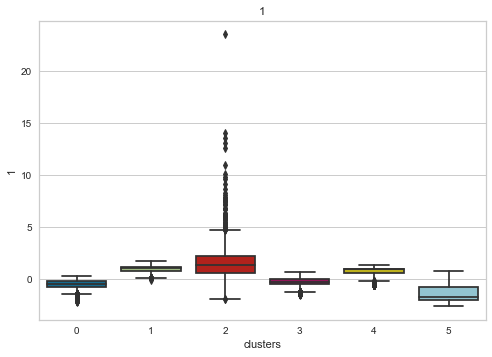

2 --> 1.3744868147847724
3 --> -0.3703240278060035
0 --> -0.5662152723731706
1 --> 0.9628585589711417
5 --> -1.516465011312778
4 --> 0.7607476385096379


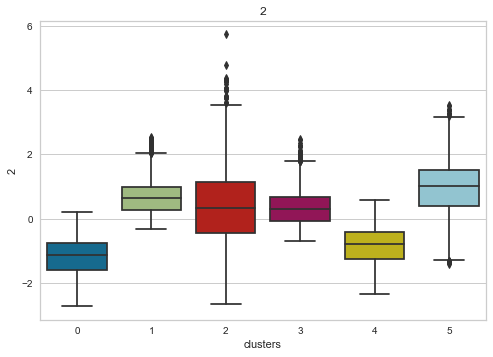

2 --> 0.3775848757674322
3 --> 0.31812501713285285
0 --> -1.1980858961607124
1 --> 0.6382031344924433
5 --> 0.9347077703143818
4 --> -0.8350359231293752


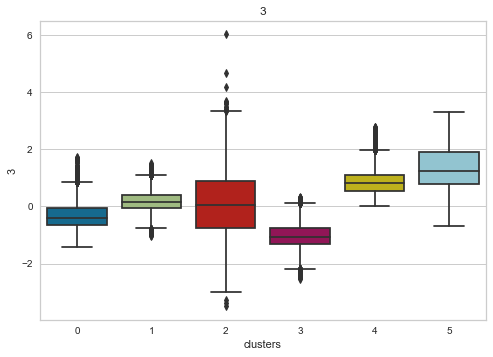

2 --> 0.047272554703449654
3 --> -1.0134540836497383
0 --> -0.3317540174961176
1 --> 0.21189416316365495
5 --> 1.3391767981368847
4 --> 0.8875862297177041


In [234]:
ploting(df_pca, [0, 1, 2, 3], 'clusters')

In [235]:
a = df_pca[[0, 1, 2, 3]]
b = df_pca['clusters']
silhouette_score(a, b)

0.35448348614132597

# Clustering hiérarchique

In [236]:
X = df_normalised
X_reduced = X.sample(int(len(X) / 5))
X_hierarchcal = X_reduced[['recently_order',
                           'cum_sum_order',
                           'number_of_orders',
                           'customer_state_encode',
                           'mean_review_score']]

In [237]:
nb_clusters = {}
for i in range(50, 150, 2):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold=i)
    model.fit(X_hierarchcal)
    X_hierarchcal['labels'] = model.labels_
    nb_clusters[i] = X_hierarchcal['labels'].nunique()

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is 

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is 

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is 

In [238]:
for key, value in nb_clusters.items():
    print(key, '----->', value)

50 -----> 12
52 -----> 12
54 -----> 12
56 -----> 12
58 -----> 12
60 -----> 12
62 -----> 12
64 -----> 12
66 -----> 12
68 -----> 12
70 -----> 12
72 -----> 12
74 -----> 12
76 -----> 12
78 -----> 12
80 -----> 11
82 -----> 10
84 -----> 9
86 -----> 9
88 -----> 9
90 -----> 9
92 -----> 9
94 -----> 9
96 -----> 8
98 -----> 8
100 -----> 8
102 -----> 7
104 -----> 6
106 -----> 6
108 -----> 6
110 -----> 6
112 -----> 6
114 -----> 6
116 -----> 6
118 -----> 5
120 -----> 5
122 -----> 5
124 -----> 5
126 -----> 5
128 -----> 5
130 -----> 5
132 -----> 5
134 -----> 5
136 -----> 5
138 -----> 5
140 -----> 4
142 -----> 4
144 -----> 4
146 -----> 4
148 -----> 4


In [72]:
# 99 semble la plus petite value pour attenidre 7 clusters

In [239]:
model = AgglomerativeClustering(n_clusters=None,
                                distance_threshold=120)
model.fit(X_hierarchcal)
X_hierarchcal['clusters'] = model.labels_

In [240]:
X_hierarchcal['clusters'].value_counts()

0    8576
2    6573
3    2777
1     716
Name: clusters, dtype: int64

In [241]:
test = pd.concat([X_hierarchcal,
                  X_reduced['customer_unique_id']],
                 axis=1)

In [242]:
test

,recently_order,cum_sum_order,number_of_orders,customer_state_encode,mean_review_score,labels,clusters,customer_unique_id
102733,1.634430,-0.442755,-0.186531,-0.574707,-0.116841,0,0,66e05eb40f8d647c2a68e9794fbdb010
56546,-0.973144,0.381934,-0.186531,-1.134137,-0.116841,0,0,a8df31b568556605935ad291fa8cc166
68130,0.146676,0.803759,-0.186531,1.149382,-1.678248,2,3,46fae5e7a53feb44b1d3922d4cd51694
22290,-0.611482,-0.662911,-0.186531,1.149382,-2.458952,2,3,d34a190fae089f2ab716f4fe20748638
47014,2.240287,-0.281514,-0.186531,-1.022171,0.663862,0,0,a78e22cba17a2973cf70d283b4119b5a
...,...,...,...,...,...,...,...,...
36686,-1.109239,-0.703136,-0.186531,-0.574707,0.663862,0,0,fca35a08a91d4a9254cc99889fc3d9c5
104338,1.157467,-0.375035,-0.186531,1.149382,0.663862,3,2,c6d41ce217f6885c81ecf5fe91880309
40531,1.145341,-0.580564,-0.186531,-1.110879,0.663862,0,0,0af92d2ac166e21f4c91e660504a5d47
29303,-0.927829,0.498750,3.777570,-0.498519,0.663862,1,1,28aea3e12549a3611bbd8d4e3310e4fa


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


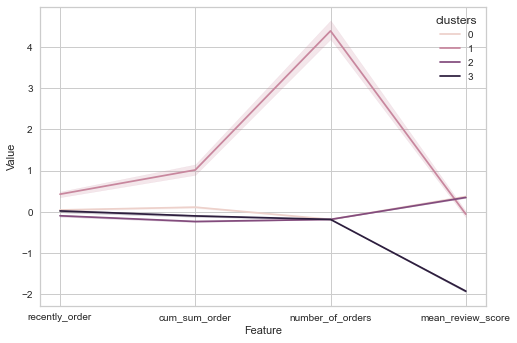

In [243]:
lineploting(test, ['recently_order',
                   'cum_sum_order',
                   'number_of_orders',
                   'mean_review_score'])

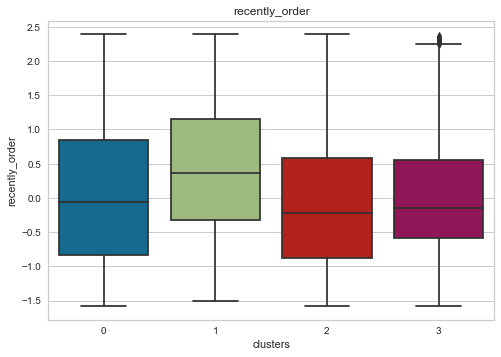

0 --> 0.04226015881812094
3 --> 0.019526304849162558
2 --> -0.09783835464405091
1 --> 0.4257190222350224


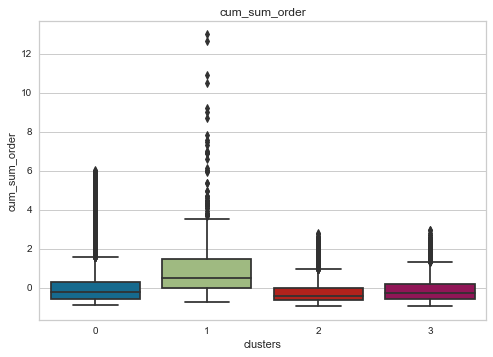

0 --> 0.1102837375292025
3 --> -0.10161835372326182
2 --> -0.23676628734449776
1 --> 1.0133699677682806


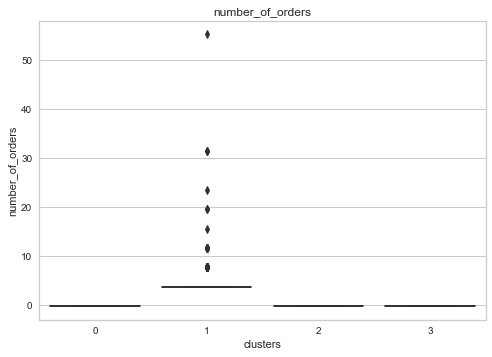

0 --> -0.1865309220940489
3 --> -0.1865309220940383
2 --> -0.18653092209403116
1 --> 4.386580077087428


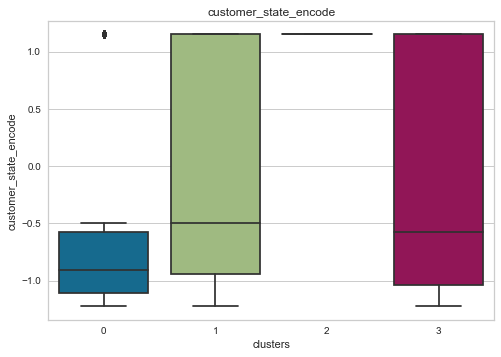

0 --> -0.7909359609045505
3 --> -0.24464387407721822
2 --> 1.1493822642549099
1 --> 0.07127205331943405


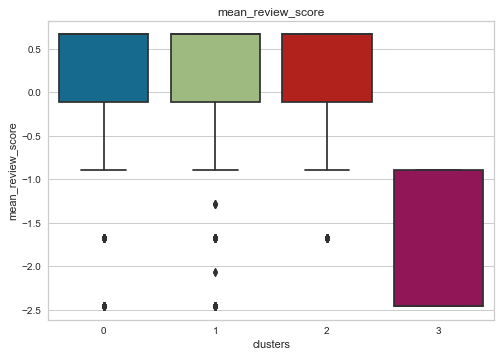

0 --> 0.36826966386117477
3 --> -1.926909425773906
2 --> 0.3464541572078483
1 --> -0.05856212147343409


In [247]:
ploting(X_hierarchcal, ['recently_order',
                        'cum_sum_order',
                        'number_of_orders',
                        'customer_state_encode',
                        'mean_review_score'], 'clusters')

In [248]:
h = X_hierarchcal.drop(columns='labels')
Z = hierarchy.linkage(h, method="ward")


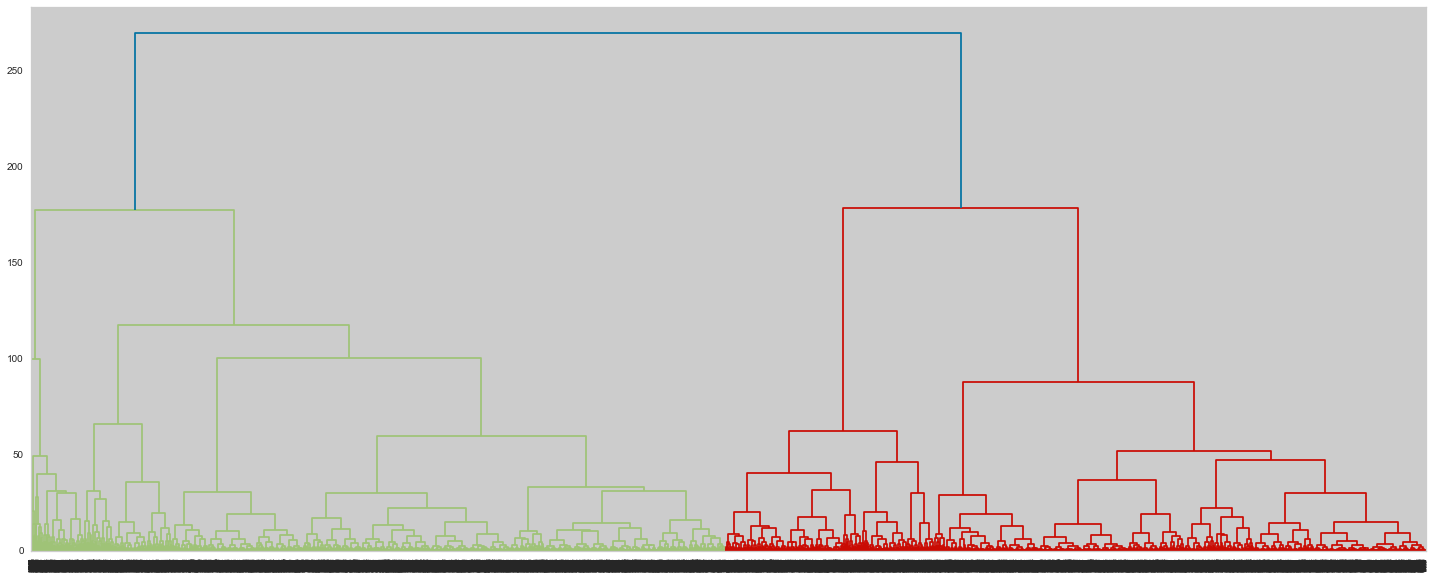

In [246]:
figure = plt.figure(figsize=(25, 10))
den = dendrogram(Z)

# DBSCAN

https://medium.com/mlearning-ai/demonstrating-customers-segmentation-with-dbscan-clustering-using-python-8a2ba0db2a2e

In [81]:
# -1 -> anomalies

In [249]:
X_db_scan = X_reduced.drop(columns=['customer_unique_id'])

In [250]:
clustering = DBSCAN(eps=3, min_samples=100).fit(X_db_scan)
clustering.labels_


array([0, 0, 0, ..., 0, 1, 0])

In [260]:
for i in np.arange(1, 20, 0.5):
    clustering = DBSCAN(eps=i, min_samples=100).fit(X_db_scan)
    col = 'eps' + str(i)
    X_db_scan[col] = clustering.labels_

In [259]:
X_db_scan['eps9.5'].value_counts()

 0     12330
 9      1040
 11      651
 1       606
 7       583
 4       581
 12      432
 10      365
 13      365
 2       315
 5       297
 14      287
 3       242
 15      194
 6       117
 8       116
 16      114
-1         7
Name: eps9.5, dtype: int64

In [ ]:
# le DBSCAN ne semble pas pertinent pour créer des clusters fiables

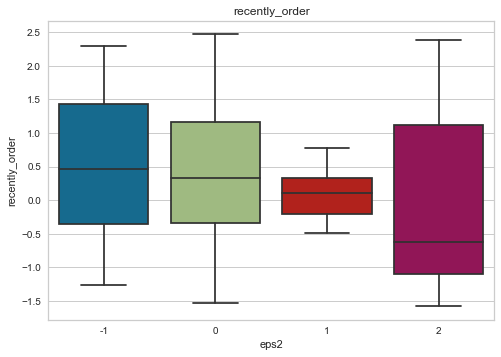

0 --> 0.39894249974917084
1 --> 0.08714490713064077
2 --> -0.07674096219564724
-1 --> 0.49159257227522396


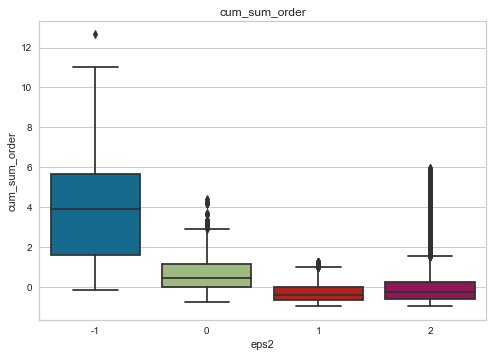

0 --> 0.6962357001261695
1 --> -0.26103902464982
2 --> 0.06781745367547956
-1 --> 3.941062191323313


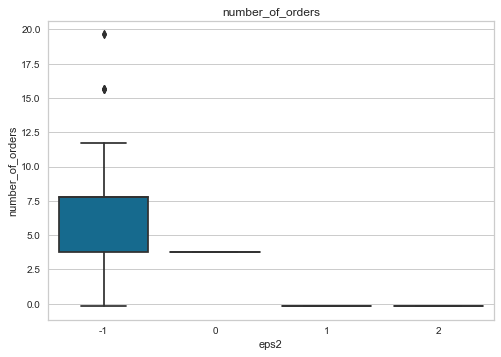

0 --> 3.7775701377291178
1 --> -0.1865309220940274
2 --> -0.18653092209405192
-1 --> 6.894641056564516


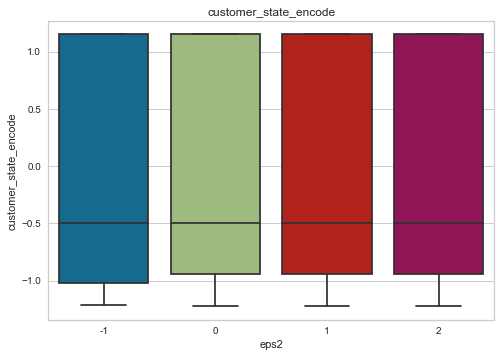

0 --> 0.014313920769598842
1 --> -0.02358254467044493
2 --> 0.010926374519267572
-1 --> -0.06106952054420319


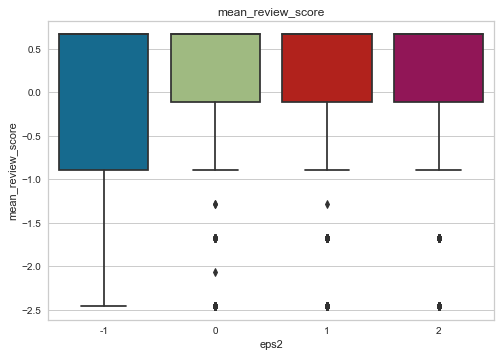

0 --> -0.0515877098271516
1 --> -0.0810482807976034
2 --> 0.051931828029697084
-1 --> -0.21693137736155021


In [91]:
ploting(X_db_scan, ['recently_order',
                    'cum_sum_order',
                    'number_of_orders',
                    'customer_state_encode',
                    'mean_review_score'], 'eps2')